# Generating Randoms in Pixelated Masks

Here we explore algorithms to generate randoms in either flat healpix maps or multi-order maps
-----------------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from mocpy import MOC
import healpy as hp
from astropy.table import Table
import healsparse

# Genetate the cone we will be working with
cone = MOC.from_cone(30*u.arcmin, 5*u.arcmin, radius=3*u.arcmin, max_depth=15, delta_depth=0)

In [2]:
cone

11/18524792-18524793 18524795-18524796 18524798 
12/74099147 74099150-74099151 74099162 74099177 74099179 74099525 74099536 
13/296396582-296396583 296396585-296396587 296396594-296396595 
 296396598-296396599 296396642 296396654 296396704-296396705 296396707 
 296396713 296396760 296396762 296396784 296396786 296396792 296398085 
 296398096-296398097 296398099 296398148-296398149 
14/1185586005 1185586007 1185586013 1185586015 1185586037 1185586039 1185586045 
 1185586047 1185586133 1185586319 1185586326-1185586327 1185586339 
 1185586370-1185586371 1185586374-1185586375 1185586386-1185586387 1185586390 
 1185586574 1185586608 1185586610-1185586611 1185586620 1185586622-1185586623 
 1185586824-1185586825 1185586827 1185586849 1185586860-1185586861 1185586863 
 1185587010 1185587016 1185587018-1185587019 1185587046 1185587052 1185587054 
 1185587140 1185587142 1185587148 1185587150 1185587172 1185587176-1185587178 
 1185592336-1185592337 1185592349 1185592392-1185592393 1185592395 1185

In [3]:
cone.flatten()

array([4742342653, 4742342655, 4742344020, ..., 4742370563, 4742370564,
       4742370568], dtype=uint64)

## Try randoms with a single cone - flat case

In [4]:
def get_higher_order_pixels(pixel_N, order_N, target_order):
    """Get the subpixels of high order (target_order) inside a pixel of a given order (order_N)"""
    #------------------------
    #Example usage
    #pixel_N = 19923020   # Given pixel index at order N
    #order_N = 11         # Original order
    #target_order = 12    # Higher order to get the pixels for
    #higher_order_pixels = get_higher_order_pixels(pixel_N, order_N, target_order)
    
    scaling_factor = 4 ** (target_order - order_N)
    # Calculate the starting and ending pixel indices at the higher order
    start_pixel = pixel_N * scaling_factor
    end_pixel = start_pixel + scaling_factor - 1
    
    # Return the range of pixels at the higher order
    return list(range(start_pixel, end_pixel + 1))

In [5]:
def rands_in_flatmoc(moc, nr=1000):
    """Generate randoms for a input MOC"""
    ##################################
    # First flatten the input moc to its highest order and generate a constant fraction of the desired
    # randoms in each pixel, by random subsamling among the subpixels very high order. 
    # Warning!!! This seems to introduce uniformity instead of randomness
    
    poolord = 22            # order of subpixels to sample from
    maxord = moc.max_order  # max order of the moc
    mocf = moc.flatten().astype('int')
    
    npixels = len(mocf)
    nr_per_pix = int(np.ceil(nr/npixels))
    print('Randoms per pixel = ', nr_per_pix)

    print('Pixel pool order =', poolord)
    print('Pixel pool size =', len(get_higher_order_pixels(mocf[0], maxord, poolord)))
    
    result = np.zeros(npixels*nr_per_pix, dtype='int64')
    
    for i,ipix in enumerate(mocf):
        #print(ipix)
        pixpool = get_higher_order_pixels(ipix, maxord, poolord)
        subpxs = np.random.choice(pixpool, nr_per_pix)
        result[i*nr_per_pix : (i+1)*nr_per_pix] = subpxs

    # Shuffle indexes first and then cut out the few extra indexes that enter due to rounding
    # the fraction to the upper integer
    rng = np.random.default_rng()
    rng.shuffle(result)
    nr_effective = result.shape[0]
    print('nreff=', nr_effective)
    if nr_effective > nr:  result = result[:nr]

    # Convert to angles
    ras, decs = hp.pix2ang(2**poolord, result, nest=True, lonlat=True)

    print('nran returned:', ras.shape[0])
    return ras, decs

In [6]:
xx, yy = rands_in_flatmoc(cone, nr=50000)

Randoms per pixel =  20
Pixel pool order = 22
Pixel pool size = 16384
nreff= 51900
nran returned: 50000


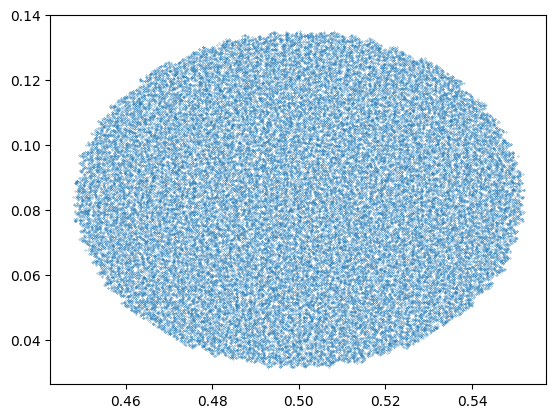

In [7]:
plt.scatter(xx, yy, s=0.05)

## Try randoms with a single cone - moc case

In [8]:
def shuffle_arrays(arrays, set_seed=-1):
    """Shuffles arrays in-place, in the same order, along axis=0

    arrays : Llist of numpy arrays
    set_seed : Seed value if int >= 0, else seed is random
    """
    assert all(len(arr) == len(arrays[0]) for arr in arrays)
    seed = np.random.randint(0, 2**(32 - 1) - 1) if set_seed < 0 else set_seed

    for arr in arrays:
        rstate = np.random.RandomState(seed)
        rstate.shuffle(arr)

In [9]:
def rands_in_moc(moc, nr=1000):
    """Generate randoms for a input MOC"""
    ##################################
    # This actually uses the moc without flattening. As, before, randoms are generated from the subpixels
    # of very high orders, but this time the fraction of randoms in each pixel is adjusted by its area. 
    # Warning!!! Looks better, but again, there is somee uniformity, as for example, all pixels of order
    # lets say 15 of the moc will have exactly the same number of randoms.
    
    poolord = 22            # order of subpixels to sample from
    maxord = moc.max_order  # max order of the moc
    smoc = cone.serialize(format='json')  #serialize to acces orders and pixels

    # Get the number of pixels of the moc
    npixels = sum(map(len, smoc.values()))
    print('npixels in moc', npixels)

    # Calculate the number of pixels that a flattened moc would have
    npixels_maxord = 0
    for key in smoc:
        n = int(key)
        npixels_maxord = npixels_maxord + 4**(maxord-n)*len(smoc[key])
    print('npixels at maxord:', npixels_maxord)

    # Estimate the fraction of rands per pixel that the flattened moc would require
    nrperpix_maxord = int(np.ceil(nr/npixels_maxord))
    print('nrand per pixel at maxord:', nrperpix_maxord)

    # Iterate for each order and pixels of that order, getting the list of subpixels
    # and choosing randomly the fraction of points adjusted by the 4^(maxord-n), i.e.
    # the ratios of the areas of those pixels
    ras = []
    decs = []
    for key in smoc:
        #print(key)
        n = int(key)
        subpxs = np.array(smoc[key])
        for i,ipix in enumerate(subpxs):
            #print(key, ipix)
            pixpool = get_higher_order_pixels(ipix, n, poolord)
            nr_thispix = nrperpix_maxord*4**(maxord-n)
            #print('nr_thispix =',nr_thispix)
            #print(key, ipix, len(pixpool), nr_thispix)
            subpxs2 = np.random.choice(pixpool, nr_thispix)
            iras, idecs = hp.pix2ang(2**poolord, subpxs2, nest=True, lonlat=True)
            ras.append(iras)
            decs.append(idecs)

    ras = np.concatenate([x.ravel() for x in ras])
    decs = np.concatenate([x.ravel() for x in decs])

    # Shuffle indexes first and then cut out the few extra indexes that enter due to rounding
    # the fraction to the upper integer
    shuffle_arrays([ras, decs])
    nr_effective = ras.shape[0]
    print('nreff=', nr_effective)
    if nr_effective > nr:
        ras = ras[:nr]
        decs = decs[:nr]
        
    print('nran returned:', ras.shape[0])
    return ras, decs

In [10]:
ii, jj = rands_in_moc(cone,50000)

npixels in moc 222
npixels at maxord: 2595
nrand per pixel at maxord: 20
nreff= 51900
nran returned: 50000


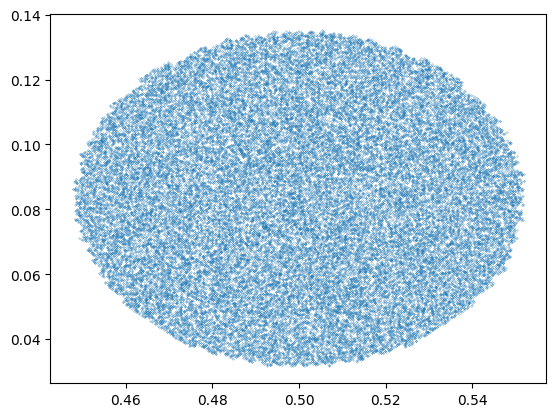

In [11]:
plt.scatter(ii, jj, s=0.05)

## Now compare both versions, flat and with moc

In [12]:
xx, yy = rands_in_flatmoc(cone, nr=250000)
ii, jj = rands_in_moc(cone, nr=250000)

Randoms per pixel =  97
Pixel pool order = 22
Pixel pool size = 16384
nreff= 251715
nran returned: 250000
npixels in moc 222
npixels at maxord: 2595
nrand per pixel at maxord: 97
nreff= 251715
nran returned: 250000


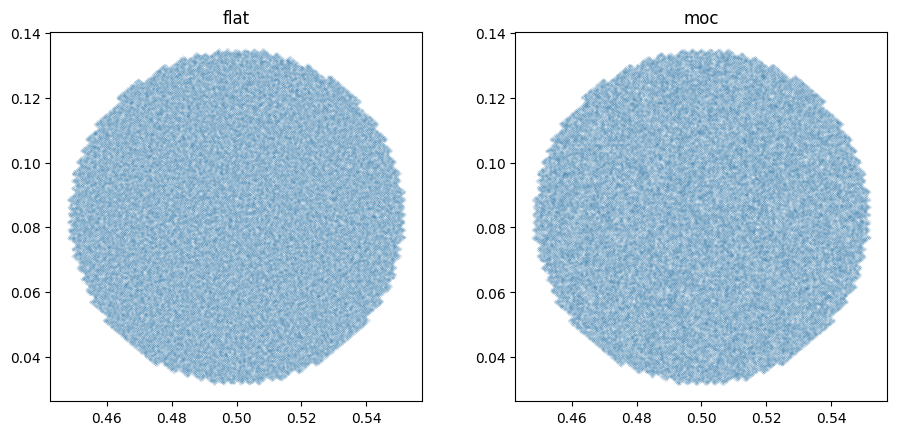

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ps = 0.001  # point size
ax1.scatter(xx, yy, s=ps);  ax1.set_title('flat');  ax1.set_aspect(1)
ax2.scatter(ii, jj, s=ps);  ax2.set_title('moc');  ax2.set_aspect(1)
fig.set_figwidth(11)

In [541]:
# Save to file to explore with topcat
Table(np.vstack([xx,yy]).T, names=['ra','dec']).write('ran_flat.fits')
Table(np.vstack([ii,jj]).T, names=['ra','dec']).write('ran_moc.fits')

## Try randoms with single cone - healsparse

In [14]:
circ = healsparse.Circle(ra=0.5, dec=5./60, radius=3./60., value=1)
smap = circ.get_map(nside_coverage=32, nside_sparse=2**15, dtype=np.int16)
ra_rand, dec_rand = healsparse.make_uniform_randoms_fast(smap, 250_000)

# Save to file to explore with topcat
#Table(np.vstack([ra_rand,dec_rand]).T, names=['ra','dec']).write('ran_healsp.fits')

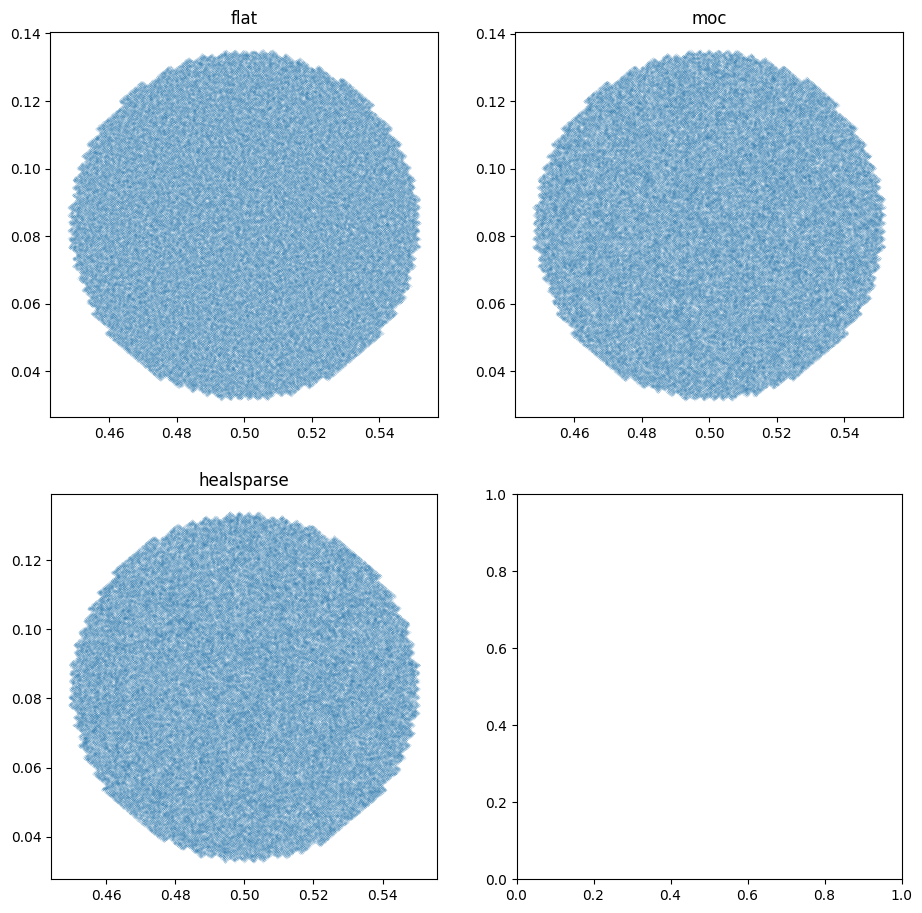

In [15]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2)
ps = 0.002  #point size
ax1.scatter(xx, yy, s=ps);  ax1.set_title('flat');  ax1.set_aspect(1)
ax2.scatter(ii, jj, s=ps);  ax2.set_title('moc');  ax2.set_aspect(1)
ax3.scatter(ra_rand, dec_rand, s=ps);  ax3.set_title('healsparse');  ax3.set_aspect(1) 
ax4.set_aspect(1)
fig.set_figwidth(11);  fig.set_figheight(11)

**The moc version looks similar as healsparse and definitely the flat case is not random**

## Try randoms with a single cone - flat case - use hpgeom to pixelate

In [136]:
import hpgeom as hpgeo
hpcirc = hpgeo.query_circle(2**15, 0.5, 5./60, 3./60, inclusive=True, fact=4, nest=True, lonlat=True, degrees=True)

In [137]:
def rands_in_flatmoc(moc, nr=1000):
    poolord = 22
    maxord = 15
    mocf = moc.astype('int')
    
    npixels = len(mocf)
    nr_per_pix = int(np.ceil(nr/npixels))
    print('Randoms per pixel = ', nr_per_pix)

    print('Pixel pool order =', poolord)
    print('Pixel pool size =', len(get_higher_order_pixels(mocf[0], maxord, poolord)))
    
    result = np.zeros(npixels*nr_per_pix, dtype='int64')
    
    for i,ipix in enumerate(mocf):
        #print(ipix)
        pixpool = get_higher_order_pixels(ipix, maxord, poolord)
        subpxs = np.random.choice(pixpool, nr_per_pix)
        result[i*nr_per_pix : (i+1)*nr_per_pix] = subpxs

    rng = np.random.default_rng()
    rng.shuffle(result)
    
    nr_effective = result.shape[0]
    print('nreff=', nr_effective)
    if nr_effective > nr:  result = result[:nr]
    
    ras, decs = hp.pix2ang(2**poolord, result, nest=True, lonlat=True)

    print('nran returned:', ras.shape[0])
    return ras, decs

In [138]:
xx, yy = rands_in_flatmoc(hpcirc, nr=250000)

Randoms per pixel =  97
Pixel pool order = 22
Pixel pool size = 16384
nreff= 250745
nran returned: 250000


In [139]:
Table(np.vstack([xx,yy]).T, names=['ra','dec']).write('ran_hpgeom.fits')

## 2dn try flat : use double random

In [105]:
def rands_in_flatmoc2(moc, nr=1000):
    """Generate randoms for a input MOC"""
    ##################################
    # First flatten the input moc to its highest order but this time choice randomly among its pixels
    # the total number of desired randoms, and for each choose at random ONE of its subpixels as the 
    # accepted rnd position. 
    # This seems to get rid of uniformity but it is very very slow !!!!
    
    poolord = 22            # order of subpixels to sample from
    maxord = moc.max_order  # max order of the moc
    mocf = moc.flatten().astype('int')
    
    npixels = len(mocf)
    nr_per_pix = int(np.ceil(nr/npixels))
    print('Randoms per pixel = ', nr_per_pix)

    print('Pixel pool order =', poolord)
    print('Pixel pool size =', len(get_higher_order_pixels(mocf[0], maxord, poolord)))

    # random oversampling of the flattened moc pixels
    mocfr = np.random.choice(mocf, size=nr, replace=True)

    result = np.empty(0, dtype=int)    
    for i,ipix in enumerate(mocfr):
        if np.mod(i,10000)==0: print(i)
        #print(ipix)
        pixpool = get_higher_order_pixels(ipix, maxord, poolord)
        subpxs = np.random.choice(pixpool, 1)  # Choose only one subpixel
        result = np.concatenate([result, subpxs])

    ras, decs = hp.pix2ang(2**poolord, result, nest=True, lonlat=True)

    print('nran returned:', ras.shape[0])
    return ras, decs

In [106]:
a, b = rands_in_flatmoc2(cone, nr=250000)

Randoms per pixel =  98
Pixel pool order = 22
Pixel pool size = 16384
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
nran returned: 250000


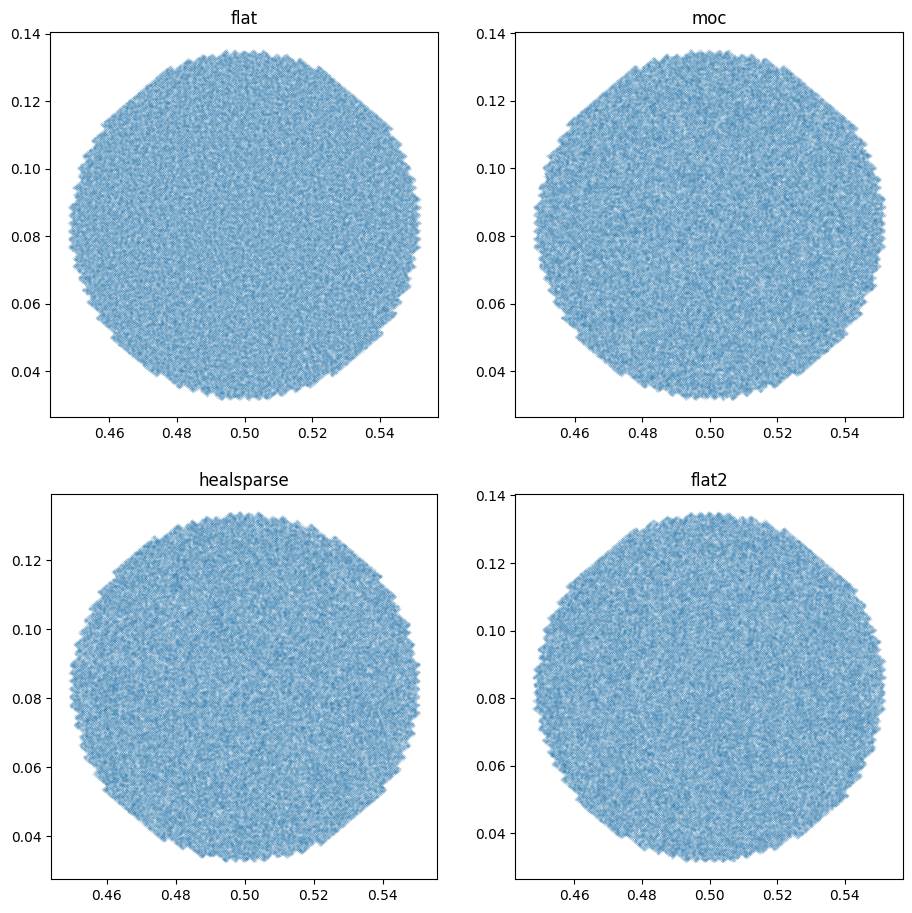

In [108]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2)
ps = 0.002  #point size
ax1.scatter(xx, yy, s=ps);  ax1.set_title('flat');  ax1.set_aspect(1)
ax2.scatter(ii, jj, s=ps);  ax2.set_title('moc');  ax2.set_aspect(1)
ax3.scatter(ra_rand, dec_rand, s=ps);  ax3.set_title('healsparse');  ax3.set_aspect(1) 
ax4.scatter(a, b, s=ps);  ax4.set_title('flat2'); ax4.set_aspect(1)
fig.set_figwidth(11);  fig.set_figheight(11)

In [109]:
# Save to file to explore with topcat
Table(np.vstack([a,b]).T, names=['ra','dec']).write('ran_flat2.fits')

In [113]:
xx, yy = rands_in_flatmoc(cone, nr=250000)

Randoms per pixel =  97
Pixel pool order = 22
Pixel pool size = 16384
nreff= 251715
nran returned: 250000


In [115]:
Table(np.vstack([xx,yy]).T, names=['ra','dec']).write('ran_flat_ddepth0.fits')